# OPTRAM

In [6]:
import os
import pandas as pd
import utm 
import folium
import re
from pathlib import Path
import geopandas as gpd
from shapely import geometry
from osgeo import gdal, gdalconst
import rasterio
import numpy as np
import numpy.ma as ma
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import datetime
import math
import rasterio as rs
import sys
import glob
import haversine as hs
from haversine import Unit
from shapely.geometry import Point
import pickle
from dask.distributed import Client
import dask.dataframe as dd
import dask
import datashader as ds
import colorcet as cc
import numpy
import seaborn as sns

### Functions

In [7]:
def utm_to_latlon(coords, zone_number = 12, zone_letter = 'N'):
    easting = coords[0]
    northing = coords[1]
    return utm.to_latlon(easting, northing, zone_number, zone_letter)

def S2_getDate(filename) :
    basename = Path(filename).stem  
    try :
        found = re.search('S2(A|B)2A_(\d+)_.*',basename).group(2)
        dt = datetime.datetime.strptime(found, '%Y%m%d')
        
    except AttributeError:
        raise ValueError('Error: Date can not be extracted from filename %s .' % filename)
        
    return dt

# TODO unify funcs S2_get*
def S2_getSCL(BASE_DIR, date) :
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
    
    pattern = BASE_DIR + '*' + date_str + '*'
    
    try: 
        filepath = glob.glob(pathname = pattern)
        return filepath[0]
    
    except AttributeError: 
        print('Error: File with pattern %s not found' % pattern)
        
def S2_getNDVI(BASE_DIR, date) :
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
    
    pattern = BASE_DIR + '*' + date_str + '*'
    
    try: 
        filepath = glob.glob(pathname = pattern)
        return filepath[0]
    
    except Exception as e: 
        print('Error while reading file %s' % pattern)
        print(e)
        
def S2_get_sensing_dt(boa_fp):
    days_offset = 1
    start_dt = S2_getDate(boa_fp) - datetime.timedelta(days=days_offset)
    end_dt   = S2_getDate(boa_fp) + datetime.timedelta(days=days_offset)
    
    start_dt = start_dt.strftime('%Y-%m-%d')
    end_dt   = end_dt.strftime('%Y-%m-%d')

    now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
    print('[%s] : Requesting image metadata between %s <-> %s...' % (now, start_dt, end_dt))
    # bash callback: 
    dts = ! Rscript ./sen2r/sat_sensing_dt.R $start_dt $end_dt ./sen2r/Walnut-Gulch.geojson 2> /dev/null
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    sensing_datetime = datetime.datetime.strptime(dts[1], '                                        "%Y-%m-%d %H:%M:%S UTC" ')
    return sensing_datetime


def is_defective_px(SCL_px_val):
    
    if ((SCL_px_val == 4) | (SCL_px_val == 5)): # vegetated OR not_vegetated
        return False
    
    else : 
        return True

# Vectorized version
is_defective_px_vect = np.vectorize(is_defective_px)

# TODO: maybe in the denominator are included alpha values and thus
# computing an undervaluated percentage ?
# TODO type checks 
# TODO shape checks  
def S2_defective_px_perc(scl_raster) : 
    not_defective = sum(~np.array(is_defective_px_vect(scl_raster)))
    perc = not_defective / len(np.ndarray.flatten(scl_raster))
    return perc

def get_px_coords_from_raster(boa, no_data, band) :
    print('[%s] : Retrieving px location coords...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    dataset = boa
    val = boa.read(band, masked = True)
    #no_data = dataset.nodata
    geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
    coords_utm = [(point.x, point.y)  for point in geometry]
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
    return (zip(*coords_utm))


def build_inSitu_obs(df, dest_lat_lng, sensor_df, dists, sensor_name, utm_n = 12, utm_z = 'N') :
    
    # Calculate the closest image pixel(row) to the sensor
    x = df.loc[:,'utm_x'].tolist()
    y = df.loc[:,'utm_y'].tolist()

    df['dist'] = [float(dist) for dist in dists] # TODO 'dists' should already be a float list.
    df['sensor_name'] = sensor_name
    print('[%s] : Sorting %d rows...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), len(df)))
    df.sort_values('dist', inplace = True)
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    df = df.head(1)
    df.set_index('datetime', inplace = True) # indexing is costly, but only one 1 obs, see previous line
    
    # Get the corresponding sensor obs to the pixel
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    def nearest(items, pivot):
        return min(items, key=lambda x: abs(x - pivot))
              
    nearest_dt = nearest(items = sensor_df.index, pivot = df.index[0])
    val = sensor_df.loc[sensor_df.index == nearest_dt, 'SM5'].values
    print('nearest_dt: %s, %s'% (nearest_dt, val))
    df.loc[:,'SM5'] = float(val)
    #df['SM5'] = float(val)
    return df


def get_haversine_dist_df(utm_coords, sensor_coords, sensor_name, utm_n = 12, utm_z = 'N') : 
   # Calculate the closest image pixel to the sensor
    #x = sensor_df.loc[:,'utm_x'].tolist()
    #y = sensor_df.loc[:,'utm_y'].tolist()

    print('[%s] : Calculating haversine distance for sensor %s...'
          % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), sensor_name))
    
    dists = [  hs.haversine(utm_to_latlon(utm_coord, utm_n, utm_Z),
                            sensor_coords, unit = Unit.METERS)
        
               for utm_coord in utm_coords 
    ]
    
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    return(dists)

def get_distances_pxs_to_sensor(boa_dummy, sensors_coords, utm_x, utm_y):
    #boa_fp = BASE_DIR_BOA + boa_files[0]
    #boa_dummy  = rs.open(boa_fp)
    h_dists = { sensor_name : get_haversine_dist_df(utm_coords = zip(utm_x, utm_y),
                                                    sensor_coords = sensors_coords[sensor_name],
                                                    sensor_name = sensor_name) 
                    for sensor_name, sensor_coords in sensors_coords.items()} 
    return (h_dists)

def resample_raster_gdal_nn(input_file, ref_file, out_file):
    # Opening input
    input = gdal.Open(input_file, gdalconst.GA_ReadOnly)
    inputProj = input.GetProjection()
    inputTrans = input.GetGeoTransform()

    # Opening ref
    reference = gdal.Open(ref_file, gdalconst.GA_ReadOnly)
    referenceProj = reference.GetProjection()
    referenceTrans = reference.GetGeoTransform()
    bandreference = reference.GetRasterBand(1)    
    x = reference.RasterXSize 
    y = reference.RasterYSize

    # Resampling
    driver= gdal.GetDriverByName('GTiff')
    output = driver.Create(out_file,x,y,1,bandreference.DataType)
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)
    gdal.ReprojectImage(input,output,inputProj,referenceProj,gdalconst.GRA_NearestNeighbour)
    del output
    del input
    del reference

def add_scl_col(scl_fp, ndvi_fp, local_df, date,  scl_dir = "./sen2r/out/SCL_res10/"):
    #input_file = scl_fp
    #ref_file = ndvi_fp
    #tempfile ?
    #out_file = "./SCL_resampled_10_gdal_" + raster_date.strftime("%Y-%m-%d") + ".tif"
    
    if os.path.isdir(scl_dir):
        pass
    else:
        os.mkdir(scl_dir)
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
        
    scl_10_fp = os.path.join(scl_dir, date_str + "_SCL_10m_resampled_by_gdal.tif")
    resample_raster_gdal_nn(input_file = scl_fp,
                            ref_file   = ndvi_fp,
                            out_file   = scl_10_fp)

    scl_10_dataset  = rs.open(scl_10_fp)
    scl_10          = scl_10_dataset.read(1, masked = True)
    scl_10_flatten  = np.ndarray.flatten(scl_10) 

    # TODO: May this be precomputed for speed-up ?
    #   - Theoretically yes, since the SCL resampled rasters should have the same dims 
    x,y = get_px_coords_from_raster(scl_10_dataset,
                                    no_data = 0,
                                    band = 1) 

    scl_10_df = pd.DataFrame({
        'utm_x' : x,
        'utm_y' : y,
        'scl_value' : np.delete(scl_10_flatten, scl_10_flatten == 0)
    })
    scl_10_df = scl_10_df.astype('int')    
    local_df = pd.merge(local_df, scl_10_df, on = ["utm_x", "utm_y"], how = "left")
    return(local_df)

In [8]:
if False: # Do not run
    
    fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
    print(S2_getDate(fname))
    
    SCL_file = S2_getSCL(BASE_DIR, date = '20181213')  
    print(SCL_file)
    

## REGION OF STUDY


In [9]:
swrc = gpd.read_file('./WG-boundary/boundary/boundary.shp')
swrc

MAJOR_SUBW   Shape_Leng    Shape_Area  \
0         1.0  78272.01636  1.477542e+08   

                                            geometry  
0  POLYGON ((605817.380 3515703.128, 605817.505 3...

Plotting with Folium requires lat, long data, so we have to convert from UTM

In [10]:
# Arizona
utm_N = 12 
utm_Z = 'N'

x,y = swrc.geometry[0].exterior.coords.xy
points = []
for i in range(len(swrc.geometry[0].exterior.coords.xy[1])) : 
    points.append(utm_to_latlon(coords = [x[i], y[i]],
                                zone_number = utm_N,
                                zone_letter = utm_Z))
 

points_rev = [(y,x) for x,y in points]
swrc['geometry'] = geometry.Polygon(points_rev)

Also we want to plot the locations of ground probes: 

In [11]:
# https://www.tucson.ars.ag.gov/dap/dap_docs/soil.html


sensor_coords_utm = {'rg13vt19'  : [586110, 3510185],
                     'rg14vt19'  : [585442, 3507187],
                     #'rg18vt19'  : [586710, 3508098],
                     'rg20vt19'  : [587480, 3504939],
                     'rg28vt19'  : [590624, 3509990],
                     'rg34vt19'  : [590946, 3507458],
                     'rg37vt19'  : [593303, 3506068],
                     'rg40vt19'  : [593360, 3510286],
                     'rg46vt19'  : [595289, 3508655],
                     'rg57vt19'  : [596089, 3510781],
                     'rg69vt19'  : [603916, 3515463],
                     'rg70vt19'  : [604288, 3514207],
                     'rg76vt19'  : [582624, 3509679],
                     'rg82vt19'  : [600154, 3511680],
                     'rg83vt19'  : [589679, 3512426],
                     'rg89vt19'  : [596308, 3513931],
                     'rg92vt19'  : [581888, 3511774],
                     'rg100vt19' : [593266, 3504720]
}

sensors_coords = {s_key : utm_to_latlon(s_utm, utm_N, utm_Z) 
                  for s_key, s_utm in sensor_coords_utm.items()}

In [12]:
m = folium.Map(location = [31.713068,  -110.025442],
               zoom_start = 11,
               tiles = "CartoDB positron")

for _, r in swrc.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
    
for sensor_key, sensor_coords in sensors_coords.items():
    
    folium.Marker(sensor_coords, popup=sensor_key).add_to(m)
    m.add_child(folium.ClickForMarker(popup="Waypoint"))

m

 Shapefile to geojson conversion

In [13]:
swrc.to_crs(epsg=4326)
swrc.to_file('./sen2r/Walnut-Gulch.geojson', driver='GeoJSON')

/home/vyago/miniconda3/envs/spatial/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## LOAD DATA

### Sensor 

In [14]:
 %%time

sensor_path = "./sensor_data"
sensors_df = {}
    
if False: 
    # TODO : check existence of sensor_path folder
    names = ["site", "year", "day", "hr", "mn", "SM5", "SM15", "SM30", "SM50", "SM75", "SM100", "SM200"]
    url_base = 'https://www.tucson.ars.ag.gov/metDAP/'
    for sensor_key,_ in list(sensors_coords.items()) :
        print("Processing sensor %s" % sensor_key)
        try: 
            if 'rg' in sensor_key :

                sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',
                                                     sep='\,', 
                                                     names = names,
                                                     engine='python')
            else :
                sensors_df[sensor_key] = pd.read_csv(url_base + 'SoilProfileSiteData/' + sensor_key +'.out',
                                                     sep='\s+', 
                                                     names = names,
                                                     engine='python')


            sensors_df[sensor_key]['datetime'] = (pd.to_datetime(sensors_df[sensor_key]['year'] * 1000 + sensors_df[sensor_key]['day'], format='%Y%j') 
                                                  +
                                                  pd.to_timedelta(sensors_df[sensor_key]["hr"], unit="h") 
                                                  +
                                                  pd.to_timedelta(sensors_df[sensor_key]["mn"], unit="min"))

            sensors_df[sensor_key].set_index('datetime', inplace=True)
            sensors_df[sensor_key].replace(6999, None, inplace=True) 
            sensors_df[sensor_key].to_parquet(os.path.join(sensor_path, sensor_key+".parquet"), engine="fastparquet")

            #print(sensors_df[sensor_key].index)


        except Exception as e :
            print("An error occurred while reading data for sensor %s " % sensor_key)
            print("Original message: %s " % e)
            del sensors_df[sensor_key]
            del sensors_coords[sensor_key]


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [15]:
%%time
for sensor_parquet in os.listdir(sensor_path): 
    sensors_df[os.path.splitext(sensor_parquet)[0]] = pd.read_parquet(os.path.join(sensor_path, sensor_parquet), engine="fastparquet")

CPU times: user 55.6 ms, sys: 11.9 ms, total: 67.5 ms
Wall time: 66.4 ms


Both rg82 & rg83 need custom processing

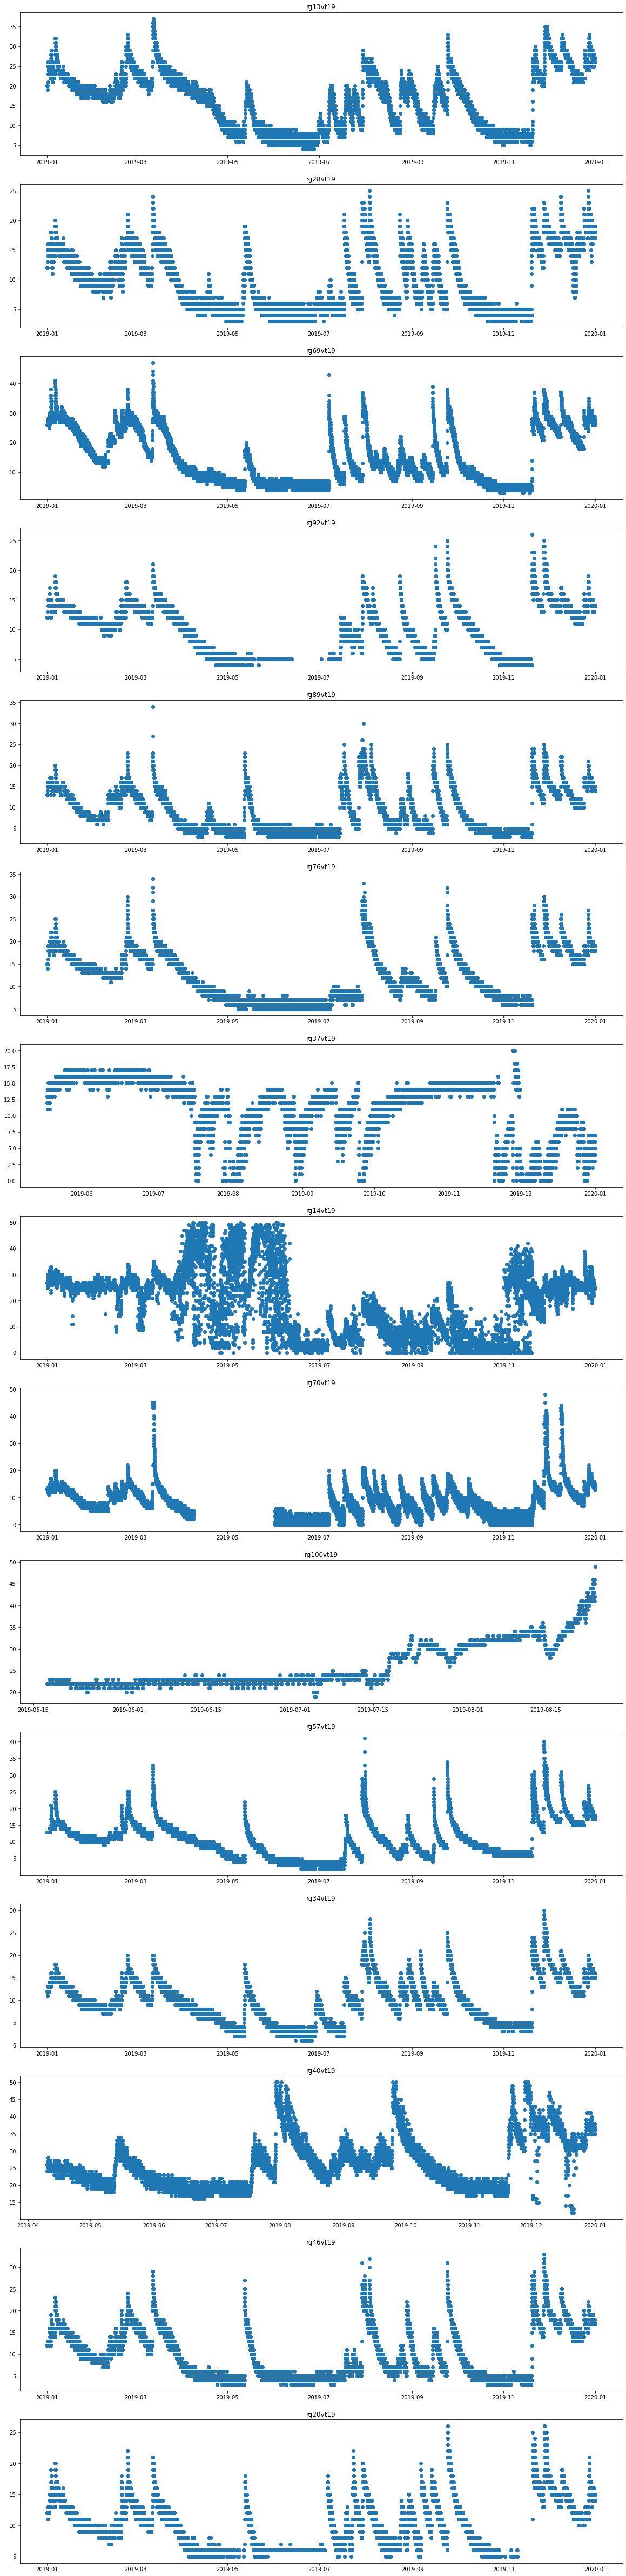

In [16]:
col_nums = 1  
row_nums = math.ceil(len(sensors_df.items()) / col_nums)
plt.figure(figsize=(20, 35))
for i, (k, df) in enumerate(sensors_df.items(), 1):
    df = sensors_df[k]
    plt.subplot(row_nums, col_nums, i)
    plt.scatter(x = df.index, y= df.loc[:,'SM5'])
    plt.title(k)
plt.subplots_adjust(left=None, bottom=None, right=None, top=2 , wspace=None, hspace=None)

### Satellite

In [17]:
BASE_DIR = './sen2r/out/'
BASE_DIR_BOA = './sen2r/out/BOA2/'
BASE_DIR_SCL = './sen2r/out/SCL/'
BASE_DIR_NDVI = './sen2r/indices/NDVI/'
BASE_DIR_SAT_IMG_DF = './sat_img_df/' # change name to differenciate from BASE_DIR which means to ./sen2r/dir

boa_files = [f for f in os.listdir(BASE_DIR_BOA,) if os.path.isfile(os.path.join(BASE_DIR_BOA, f))]

In [18]:
# ----------------------------------PRECALCULATED for speedup

if False :
    print('[%s] : ------- PRECOMPUTING  -------\n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    boa_dummy  = rs.open(BASE_DIR_BOA + boa_files[0])
    utm_x, utm_y =  get_px_coords_from_raster(boa_dummy,
                                              band = 3, # which band[R|G|B] ? 
                                              no_data = boa_dummy.nodata)
if False :
    haversine_dists = get_distances_pxs_to_sensor(boa_dummy = boa_dummy,
                                                  sensors_coords = sensors_coords,
                                                  utm_x = utm_x,
                                                  utm_y = utm_y)
    print('[%s] : ----- PRECOMPUTING DONE -----\n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    
    with open('./haversine_dists.pkl', 'wb') as f:
        pickle.dump(haversine_dists, f)
        
with open('./haversine_dists.pkl', 'rb') as f:
    haversine_dists = pickle.load(f) #TODO: 226 mb will be better use parquet format

In [19]:
# TODO check folder BASE_DIR_SAT_IMG_DF exists if not create
if False : 
    for idx,file in enumerate(boa_files) : 
        try : 
            now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
            print('[%s] : processing file (%s/%s) %s... \n' % (now, idx, len(boa_files), file))

            boa_fp = BASE_DIR_BOA + file
            raster_date = S2_getDate(boa_fp)
            scl_fp = S2_getSCL(BASE_DIR_SCL, raster_date)
            ndvi_fp = S2_getNDVI(BASE_DIR_NDVI, raster_date)

            boa  = rs.open(boa_fp)
            #scl  = rs.open(scl_fp)
            ndvi  = rs.open(ndvi_fp)

            swir = boa.read(11, masked = True)
            #scl  = scl.read(1, masked = True)
            ndvi = ndvi.read(1)
            ndvi = np.ndarray.flatten(ndvi)
            ndvi = np.delete(ndvi, ndvi == -9999.0)

            swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
            STR  = ((1-swir)**2)/(2*swir)
            STR  = np.ndarray.flatten(STR)
            STR  = np.delete(STR, STR.mask)
            
            data = {
                'datetime' : S2_get_sensing_dt(boa_fp),
                'ndvi' : ndvi,
                'str'  : STR,
                'utm_x' : utm_x, 
                'utm_y' : utm_y,
                'fpath' : boa_fp
            }
            
            local_df = pd.DataFrame(data)
            local_df.astype({
                'datetime' : 'datetime64[ns]',
                'ndvi' : 'float', 
                'utm_x' : 'float', 
                'utm_y' : 'float',
                'fpath' : 'str'
            })
            local_df = add_scl_col(scl_fp = scl_fp,
                                   ndvi_fp = ndvi_fp,
                                   local_df = local_df,
                                   date = raster_date)            
            local_df.to_parquet(os.path.join(BASE_DIR_SAT_IMG_DF,
                                             datetime.datetime.strftime(raster_date, "%Y-%m-%d")+".parquet"),
                                engine="fastparquet")
                
            print(local_df)
            
        except Exception as e : 
            print("An error occurred while processing data for file %s " % file)
            print("Original message: %s " % e)

_You want the number of processes times the number of threads to equal the number of cores._  
- https://stackoverflow.com/questions/51099685/best-practices-in-setting-number-of-dask-workers

In [20]:
# Ryzen 5 2600: 6 cores 12 threads, 16 GB RAM
# Workaround to achieve scheduler similar to processes=False
# 
client = Client(memory_limit='12GB', # keep to 12
                processes = True,
                n_workers = 1,
                threads_per_worker = 12)
client

<Client: 'tcp://127.0.0.1:45163' processes=1 threads=12, memory=11.18 GiB>

In [ ]:
#client.close()

In [21]:
ddf = dd.read_parquet(BASE_DIR_SAT_IMG_DF + "*", engine='fastparquet')
ddf

Dask DataFrame Structure:
                      datetime     ndvi      str    utm_x    utm_y   fpath scl_value
npartitions=71                                                                      
                datetime64[ns]  float32  float64  float64  float64  object   float64
                           ...      ...      ...      ...      ...     ...       ...
...                        ...      ...      ...      ...      ...     ...       ...
                           ...      ...      ...      ...      ...     ...       ...
                           ...      ...      ...      ...      ...     ...       ...
Dask Name: read-parquet, 71 tasks

In [22]:
if False :
    ddf.info(memory_usage=True) # 6GB

In [23]:
if True : 
    
    meta = pd.DataFrame({
                  'datetime':    pd.Series(dtype='datetime64[ns]'),
                  'ndvi':        pd.Series(dtype='float'),
                  'str':         pd.Series(dtype='float'),
                  'utm_x':       pd.Series(dtype='float'),
                  'utm_y':       pd.Series(dtype='float'),
                  'fpath':       pd.Series(dtype='str'),
                  'scl_value':   pd.Series(dtype='int'),
                  'dist':        pd.Series(dtype='float'),
                  'sensor_name': pd.Series(dtype='str'),
                  'SM5':         pd.Series(dtype='float') # ??? can be cast to float or float32 ? 
    })
    
    meta.set_index("datetime", inplace=True)

    inSitu_obs_dfs_list = list()
    for sensor_name, sensor_coords in sensors_coords.items() :
        now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
        print('[%s] : processing sensor %s... \n' % (now, sensor_name))
        try : 

            inSitu_obs_df = ddf.map_partitions(build_inSitu_obs, 
                                               dest_lat_lng  = sensors_coords[sensor_name],
                                               sensor_df     = sensors_df[sensor_name],
                                               dists         = haversine_dists[sensor_name],
                                               sensor_name   = sensor_name,
                                               meta =  meta);

            inSitu_obs_dfs_list.append(inSitu_obs_df)
            del inSitu_obs_df
        except Exception as e : 
            print("An error occurred while processing data for sensor %s " % sensor_name)
            print("Original message: %s " % e)

[2022/04/06 10:35:27] : processing sensor rg13vt19... 

[2022/04/06 10:35:34] : processing sensor rg14vt19... 

[2022/04/06 10:35:39] : processing sensor rg20vt19... 

[2022/04/06 10:35:45] : processing sensor rg28vt19... 

[2022/04/06 10:35:51] : processing sensor rg34vt19... 

[2022/04/06 10:35:57] : processing sensor rg37vt19... 

[2022/04/06 10:36:03] : processing sensor rg40vt19... 



2022-04-06 10:36:08,028 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-04-06 10:36:08,368 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-04-06 10:36:08,711 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-04-06 10:36:09,048 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-04-06 10:36:09,410 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[2022/04/06 10:36:09] : processing sensor rg46vt19... 



2022-04-06 10:36:14,245 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-04-06 10:36:14,569 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-04-06 10:36:14,907 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-04-06 10:36:15,251 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-04-06 10:36:15,641 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[2022/04/06 10:36:15] : processing sensor rg57vt19... 



2022-04-06 10:36:20,509 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-04-06 10:36:20,857 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-04-06 10:36:21,200 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-04-06 10:36:21,562 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-06 10:36:21,943 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[2022/04/06 10:36:22] : processing sensor rg69vt19... 



2022-04-06 10:36:26,782 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2022-04-06 10:36:27,130 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-06 10:36:27,486 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-06 10:36:27,888 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[2022/04/06 10:36:28] : processing sensor rg70vt19... 



2022-04-06 10:36:32,703 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2022-04-06 10:36:33,036 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2022-04-06 10:36:33,404 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-06 10:36:33,776 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-06 10:36:34,178 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-06 10:36:34,559 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[2022/04/06 10:36:34] : processing sensor rg76vt19... 



2022-04-06 10:36:39,647 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-04-06 10:36:40,000 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-06 10:36:40,356 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-06 10:36:40,730 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-06 10:36:41,146 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[2022/04/06 10:36:41] : processing sensor rg82vt19... 

An error occurred while processing data for sensor rg82vt19 
Original message: 'rg82vt19' 
[2022/04/06 10:36:41] : processing sensor rg83vt19... 

An error occurred while processing data for sensor rg83vt19 
Original message: 'rg83vt19' 
[2022/04/06 10:36:41] : processing sensor rg89vt19... 



2022-04-06 10:36:46,022 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-06 10:36:46,392 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-06 10:36:46,749 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-06 10:36:47,172 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-06 10:36:47,623 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-06 10:36:48,099 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


[2022/04/06 10:36:48] : processing sensor rg92vt19... 



2022-04-06 10:36:53,136 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-06 10:36:53,512 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-06 10:36:53,903 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-06 10:36:54,298 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[2022/04/06 10:36:54] : processing sensor rg100vt19... 



2022-04-06 10:36:59,211 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-06 10:36:59,618 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-06 10:37:00,026 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-06 10:37:00,406 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-06 10:37:00,893 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-06 10:37:01,386 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


The following code fully exploits CPU parallelism but requires lots of memory to fit and inizialize the tasks. https://docs.dask.org/en/latest/best-practices.html, section _Avoid calling compute repeatedly_

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.124068 to fit


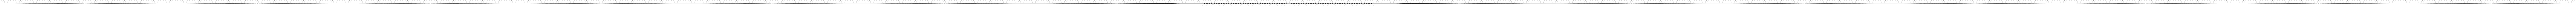

In [24]:
dask.visualize(*inSitu_obs_dfs_list)

In [25]:
# Recomended 64 GB memory
# the task graph initialization takes up 18 GB alone
if False : #do not run
    inSitu_dfs_global = dask.compute(*inSitu_obs_dfs_list)
    inSitu_dfs_global = pd.concat(inSitu_dfs_global)
    
    with open('./inSitu_dfs_global.pkl', 'wb') as f:
        pickle.dump(inSitu_dfs_global, f)   

Also we can compute indepently each item, thus requiring much less memory but loading each time the whole df datasets, as a consequence its takes sensibly longer than previous.

~ 20 mins.

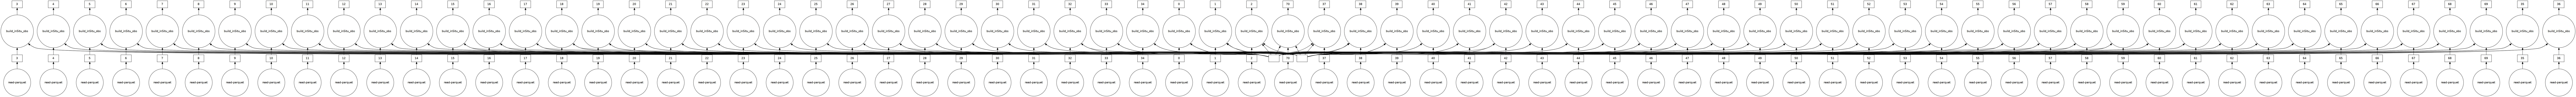

In [26]:
dask.visualize(inSitu_obs_dfs_list[0])

In [27]:
# Recomended 16 GB memory

if False : #do not run
    inSitu_dfs_global = [df.compute() for df in inSitu_obs_dfs_list]
    inSitu_dfs_global = pd.concat(inSitu_dfs_global)
    
    with open('./inSitu_dfs_global.pkl', 'wb') as f:
        pickle.dump(inSitu_dfs_global, f)   

Which alternative use, depends on the hardware.

In [28]:
with open('./inSitu_dfs_global.pkl', 'rb') as f:
    inSitu_dfs_global = pickle.load(f)

<AxesSubplot:xlabel='ndvi', ylabel='str'>

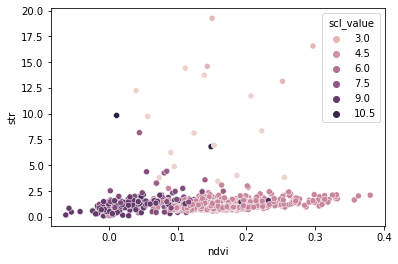

In [29]:
sns.scatterplot(x = "ndvi", y = "str", data = inSitu_dfs_global, hue="scl_value")

<AxesSubplot:xlabel='ndvi', ylabel='str'>

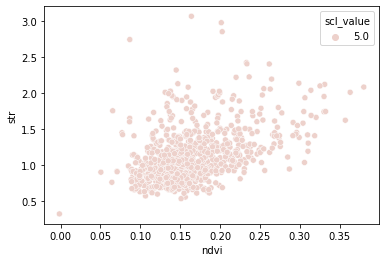

In [110]:
mask = (inSitu_dfs_global.loc[:,"scl_value"] == 4) | (inSitu_dfs_global.loc[:,"scl_value"] == 5) #vegetated % not_vegetated only
sns.scatterplot(x = "ndvi", y = "str", data = inSitu_dfs_global.loc[mask,:], hue="scl_value")

Filtering out defective pixls because of water, clouds, etc: 

In [78]:
mask = (ddf["scl_value"] == 4) | (ddf["scl_value"] == 5) #vegetated % not_vegetated only
df_global = ddf.loc[mask,["ndvi", "str"]].compute()

In [32]:
# DATASHADER
import datashader as ds

dask.visualize(ddf['ndvi'].min(),
               ddf['ndvi'].max(),
               ddf['str'].max(),
               ddf['str'].max())

ndvi_min, ndvi_max, str_min, str_max = dask.compute(ddf['ndvi'].min(),
                                                    ddf['ndvi'].max(),
                                                    ddf['str'].min(),
                                                    ddf['str'].max())

print(ndvi_min, ndvi_max, str_min, str_max)

edge_dry_intercept = (0.2, 0)
edge_dry_slope = 10

edge_wet_intercept = (0.18, 0) 
edge_wet_slope = 170

cvs = ds.Canvas(plot_width=800, plot_height=500)  # auto range or provide the `bounds` argument
plt.figure(figsize=(14, 7))

agg = cvs.points(df_global, 'ndvi', 'str')  # this is the histogram
img = ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "white").to_pil()  # create a rasterized image
plt.imshow(img, extent=[0, ndvi_max, str_min , str_max],
           aspect='auto',
           origin='upper')
plt.axline(edge_dry_intercept, slope=edge_dry_slope, linewidth = 5, color='red', label='a')
plt.axline(edge_wet_intercept, slope=edge_wet_slope, linewidth = 5, color='blue', label='b')


In [ ]:
# VAEX
import vaex
df_global_vaex = vaex.from_pandas(df=df_global)

In [ ]:
df_global_vaex.viz.heatmap("ndvi", "str",
                           limits = '97%',
                           figsize = (15, 7),
                           shape = (500,500),
                           #what = vaex.stat.mean(df_global_vaex.ndvi)**2,
                           #colorbar = False, 
                           colormap = 'afmhot');

In [ ]:
plt.axline(edge_dry_intercept, slope=edge_dry_slope, color='red', label='dry')
plt.axline(edge_wet_intercept, slope=edge_wet_slope, color='blue', label='edge')

In [ ]:
edge_dry_intercept

In [ ]:
df.plot("ndvi", "str", limits = '97%', figsize=(15, 7));

#### Fake data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({ 'x' :np.random.normal(0,1,77000000),
                    'y' : np.random.normal(0,1,77000000) })

intercept_a = (-2, 0.5)
slope_a     = 0.5

intercept_b = (-0.5, -1.5)
slope_b     = 0.1

print(df.shape)

(77000000, 2)


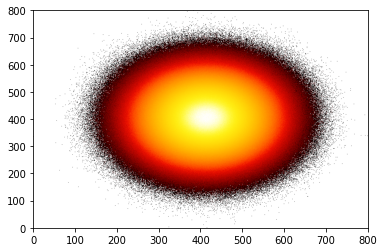

In [5]:
# DATASHADER 
import datashader as ds
import colorcet as cc

cvs = ds.Canvas(plot_width=800, plot_height=500)  # auto range or provide the `bounds` argument
agg = cvs.points(df, 'x', 'y')
img = ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "white").to_pil()
plt.imshow(img)

plt.imshow(img, extent=[0,800,0, 800], aspect='auto', origin='lower')
#plt.axline(intercept_a, slope=slope_a, color='red', label='dry')
#plt.axline(intercept_b, slope=slope_b, color='blue', label='edge')


In [ ]:
# VAEX
import vaex
df_vaex = vaex.from_pandas(df=df)


df_vaex.viz.heatmap("x", "y",
               limits = '97%',
               colorbar = False,
               colormap='autumn');

plt.axline(intercept_a, slope=slope_a, color='red', label='dry')
plt.axline(intercept_b, slope=slope_b, color='blue', label='edge')

In [ ]:
# Expected result: (but w/ 77M rows)

plt.scatter(x = df.loc[1:3000,'x'], 
            y = df.loc[1:3000,'y'])
plt.axline(intercept_a, slope=slope_a, color='red', label='dry')
plt.axline(intercept_b, slope=slope_b, color='blue', label='edge')


In [ ]:
df = pd.DataFrame({ 'x' :np.random.normal(0,1,77000000),
                    'y' : np.random.normal(0,1,77000000) })

df


intercept_a = 0
slope_a     = 0.5

intercept_b = 0
slope_b     = 0.1

cvs = ds.Canvas(plot_width=800, plot_height=500)  # auto range or provide the `bounds` argument
plt.figure(figsize=(20, 35))

agg = cvs.points(df, 'x', 'y')
img = ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "white").to_pil()  # create a rasterized image
plt.imshow(img)

plt.axline((0, edge_dry_intercept), slope=edge_dry_slope, color='red', label='dry')
plt.axline((0, edge_wet_intercept), slope=edge_wet_slope, color='blue', label='edge')
plt.axis('off')
plt.show()

# OPTRAM FIT

In [112]:
def W(STRd, STRw, STR):
    return((STR - STRd)/(STRw - STRd))

def STRd_f(intercept, slope, ndvi):
    return (intercept + slope*ndvi) 

def STRw_f(intercept, slope, ndvi):
    return (intercept + slope*ndvi)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.435986 to fit


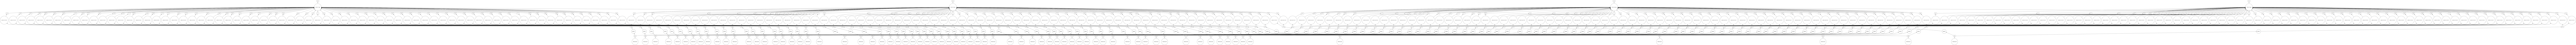

In [102]:
# DATASHADER

dask.visualize(ddf['ndvi'].min(),
               ddf['ndvi'].max(),
               ddf['str'].max(),
               ddf['str'].min())

-0.6936416 0.99941266 5.000500050003898e-09 207.33453333333335


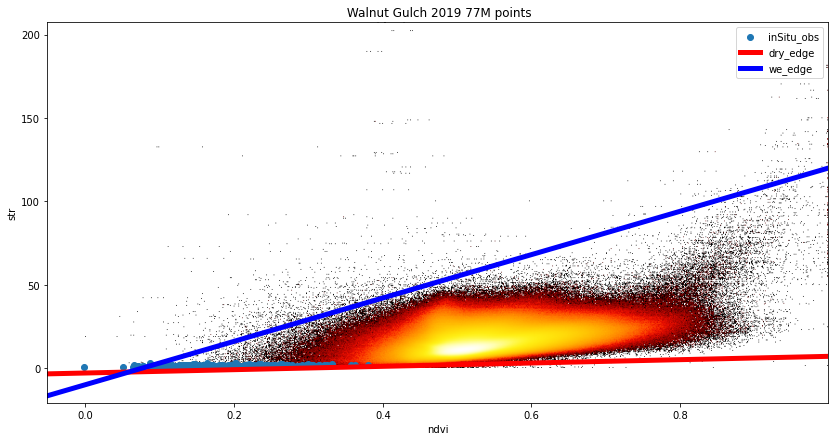

In [141]:
ndvi_min, ndvi_max, str_min, str_max = dask.compute(ddf['ndvi'].min(),
                                                    ddf['ndvi'].max(),
                                                    ddf['str'].min(),
                                                    ddf['str'].max())
print(ndvi_min, ndvi_max, str_min, str_max)

edge_dry_intercept = (0, -3)
edge_dry_slope = 10

#edge_wet_intercept = (0, 40) 
edge_wet_intercept = (0, -10) 
edge_wet_slope = 130

cvs = ds.Canvas(plot_width=800, plot_height=500)  
plt.figure(figsize=(14, 7))

agg = cvs.points(df_global, 'ndvi', 'str')  # this is the histogram
img = ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "white").to_pil() 
plt.imshow(img, extent=[0, ndvi_max, str_min , str_max],
           aspect='auto',
           origin='upper')

plt.scatter(x = inSitu_dfs_global.loc[mask, "ndvi"],
            y = inSitu_dfs_global.loc[mask, "str"], label = "inSitu_obs")

plt.axline(edge_dry_intercept, slope=edge_dry_slope,
           linewidth = 5, color='red', label='dry_edge')
plt.axline(edge_wet_intercept, slope=edge_wet_slope,
           linewidth = 5, color='blue', label='we_edge')

plt.title(" Walnut Gulch 2019 77M points")
plt.xlabel("ndvi")
plt.ylabel("str")
plt.legend()

In [ ]:
if False:
    edge_dry_intercept = -0.2
    edge_dry_slope = 2.3

    edge_wet_intercept = 1.8 
    edge_wet_slope = 4

    plt.figure(figsize=(15, 7))
    plt.scatter(df_global.loc[:,'ndvi'], df_global.loc[:,'str'])
    plt.scatter(inSitu_dfs_global.loc[:,'ndvi'], inSitu_dfs_global.loc[:,'str'], label = 'inSitu', alpha = 0.1)
    plt.axline((0, edge_dry_intercept), slope=edge_dry_slope, color='red', label='dry')
    plt.axline((0, edge_wet_intercept), slope=edge_wet_slope, color='blue', label='edge')
    plt.legend()
    plt.show()

In [135]:
str_d =  STRd_f(intercept = edge_dry_intercept[1],
                slope = edge_dry_slope,
                ndvi  = inSitu_dfs_global.loc[mask,'ndvi'])

str_w =  STRd_f(intercept = edge_wet_intercept[1],
                slope = edge_wet_slope,
                ndvi  = inSitu_dfs_global.loc[mask,'ndvi'])

In [136]:
print(str_d, str_w)

datetime
2019-01-20 18:06:49   -1.627451
2019-01-25 18:06:31   -1.798646
2019-01-30 18:06:09   -1.742515
2019-02-04 18:05:31   -1.940043
2019-03-01 18:02:49   -1.744635
                         ...   
2019-12-06 18:07:29   -0.383468
2019-12-16 18:07:39   -0.595172
2019-12-21 18:07:41   -0.768595
2019-12-26 18:07:49   -0.847600
2019-12-31 18:07:41   -0.859734
Name: ndvi, Length: 790, dtype: float32 datetime
2019-01-20 18:06:49     7.843138
2019-01-25 18:06:31     5.617598
2019-01-30 18:06:09     6.347305
2019-02-04 18:05:31     3.779443
2019-03-01 18:02:49     6.319744
                         ...    
2019-12-06 18:07:29    24.014919
2019-12-16 18:07:39    21.262768
2019-12-21 18:07:41    19.008265
2019-12-26 18:07:49    17.981197
2019-12-31 18:07:41    17.823458
Name: ndvi, Length: 790, dtype: float32


In [137]:
inSitu_dfs_global.loc[mask, "W"] = W(STRd = str_d,
                           STRw = str_w,
                           STR = inSitu_dfs_global.loc[mask,'str'])

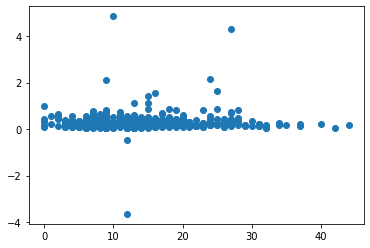

In [138]:
#inSitu_dfs_global["W_alt"] = (edge_dry_intercept + edge_dry_slope*inSitu_dfs_global.loc[:,'ndvi'] - inSitu_df.loc[:,'str'])/(edge_dry_intercept - edge_wet_intercept +(edge_dry_slope - edge_wet_slope)*inSitu_df.loc[:,'ndvi'])

plt.scatter(inSitu_dfs_global.loc[:,'SM5'], inSitu_dfs_global.loc[:,'W'])

# BASURA

In [ ]:
# https://gis.stackexchange.com/questions/394455/how-to-find-coordinates-of-pixels-of-a-geotiff-image-with-python
fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
from shapely.geometry import Point

dataset = boa
val = ndvi
no_data = dataset.nodata
geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
df = gpd.GeoDataFrame({'geometry':geometry,'data':v})
df.crs = dataset.crs
geometry

In [ ]:
print(geometry[0].xy[0])

In [ ]:
boa.read(8, masked = True)

### NDVI band vs BOA computed ndvi

In [ ]:
import rasterio as rs

# NDVI 
ndvi_fp = './sen2r/indices/NDVI/S2A2A_20190415_041_Walnut-Gulch_NDVI_10.tif'
raster = rs.open(ndvi_fp)
print(raster.meta)

In [ ]:
raster_ndvi = raster.read(1)
raster_ndvi = np.ndarray.flatten(raster_ndvi)
raster_ndvi = np.delete(raster_ndvi, raster.mask)
print(raster_ndvi)

plt.hist(raster_ndvi, bins = 100)
plt.show()

In [ ]:
#STR
BASE_DIR = './sen2r/out/'
BASE_DIR_BOA = './sen2r/out/BOA_2/'
boa_fp = "./sen2r/out/BOA_2/S2A2A_20190415_041_Walnut-Gulch_BOA_10.tif"
raster_date = S2_getDate(boa_fp)
#scl_fp = S2_getSCL(BASE_DIR, raster_date)

boa  = rs.open(boa_fp)
scl  = rs.open(scl_fp)
r    = boa.read(3, masked = True)
nir  = boa.read(8, masked = True)
swir = boa.read(11, masked = True)
swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
#ndvi = (nir - r)/(nir + r)
STR  = ((1-swir)**2)/(2*swir)
scl  = scl.read(1, masked = True)
print(boa.meta)
STR

In [ ]:
STR  = np.ndarray.flatten(STR)
STR  = np.delete(STR, STR.mask)

plt.hist(STR, bins = 100)
plt.show()

In [ ]:
STR

In [ ]:
plt.scatter(raster_ndvi, STR)
plt.show()

In [ ]:
print(len(raster_ndvi))
print(len(STR))

print(len(raster_ndvi) == len(STR))

## Resampling  SCL 60mt/px to 10mt/px

### Using gdal

https://gis.stackexchange.com/questions/234022/resampling-a-raster-from-python-without-using-gdalwar

In [ ]:
from osgeo import gdal, gdalconst


BASE_DIR_BOA  = './sen2r/out/BOA2/'
BASE_DIR_NDVI = './sen2r/indices/NDVI/'
BASE_DIR_SCL  = './sen2r/out/SCL/'


boa_files = [f for f in os.listdir(BASE_DIR_BOA) if os.path.isfile(os.path.join(BASE_DIR_BOA, f))]
boa_fp = BASE_DIR_BOA + boa_files[0]
raster_date = S2_getDate(boa_fp)
print(raster_date)
scl_fp = S2_getSCL(BASE_DIR_SCL, raster_date)
print(scl_fp)
ndvi_fp = S2_getNDVI(BASE_DIR_NDVI, raster_date)
print(ndvi_fp)

In [ ]:
def get_px_coords_from_raster(boa, no_data, band) :
    print('[%s] : Retrieving px location coords...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    dataset = boa
    val = boa.read(band, masked = True)
    #no_data = dataset.nodata
    geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
    coords_utm = [(point.x, point.y)  for point in geometry]
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
    return (zip(*coords_utm))

def resample_raster_gdal_nn(input_file, ref_file, out_file):

    # Opening input
    input = gdal.Open(input_file, gdalconst.GA_ReadOnly)
    inputProj = input.GetProjection()
    inputTrans = input.GetGeoTransform()

    # Opening ref
    reference = gdal.Open(ref_file, gdalconst.GA_ReadOnly)
    referenceProj = reference.GetProjection()
    referenceTrans = reference.GetGeoTransform()
    bandreference = reference.GetRasterBand(1)    
    x = reference.RasterXSize 
    y = reference.RasterYSize

    # Resampling
    driver= gdal.GetDriverByName('GTiff')
    output = driver.Create(out_file,x,y,1,bandreference.DataType)
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)
    gdal.ReprojectImage(input,output,inputProj,referenceProj,gdalconst.GRA_NearestNeighbour)
    del output

In [ ]:
input_file = scl_fp
ref_file = ndvi_fp
#tempfile ?
out_file = "./SCL_resampled_10_gdal_" + raster_date.strftime("%Y-%m-%d") + ".tif"

resample_raster_gdal_nn(input_file, ref_file, out_file)

scl_10_dataset  = rs.open(out_file)
scl_10          = scl_10_dataset.read(1, masked = True)
scl_10_flatten  = np.ndarray.flatten(scl_10) 


x,y = get_px_coords_from_raster(scl_10_dataset,
                                no_data = 0,
                                band = 1) 

scl_10_df = pd.DataFrame({
    'utm_x' : x,
    'utm_y' : y,
    'scl_value' : np.delete(scl_10_flatten, scl_10_flatten == 0)
})
scl_10_df = scl_10_df.astype('int32')
scl_10_df

simulating creation of local_df datarame on boa_files outer iteration

In [ ]:
boa_dummy = rs.open(boa_fp)
utm_x, utm_y =  get_px_coords_from_raster(boa_dummy, 
                                          no_data = boa_dummy.nodata,
                                          band = 3)
#boa_fp = BASE_DIR_BOA + file
print(boa_fp)
raster_date = S2_getDate(boa_fp)
scl_fp = S2_getSCL(BASE_DIR_BOA, raster_date)
ndvi_fp = S2_getNDVI(BASE_DIR_NDVI, raster_date)

boa  = rs.open(boa_fp)
scl  = rs.open(scl_fp)
ndvi  = rs.open(ndvi_fp)

swir = boa.read(11, masked = True)
scl  = scl.read(1, masked = True)
ndvi = ndvi.read(1)
ndvi = np.ndarray.flatten(ndvi)
ndvi = np.delete(ndvi, ndvi == -9999.0)

swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
STR  = ((1-swir)**2)/(2*swir)
STR  = np.ndarray.flatten(STR)
STR  = np.delete(STR, STR.mask)

# TODO : check defective_px_perc before proccess the following
# TODO : add col defective_px {Boolean}  for further filtering

data = {
        'datetime' : S2_get_sensing_dt(boa_fp),
        'ndvi' : ndvi,
        'str'  : STR,
#        'defective_px_perc' : S2_defective_px_perc(np.ndarray.flatten(scl.data)),
        'utm_x' : utm_x, 
        'utm_y' : utm_y,
        'fpath' : boa_fp
}
local_df = pd.DataFrame(data)

In [ ]:
print(len(local_df), local_df.columns)
print(len(scl_10_df), scl_10_df.columns)

In [ ]:
local_df_merged = pd.merge(local_df, scl_10_df, on = ["utm_x", "utm_y"], how = "left")
local_df_merged

In [ ]:
np.unique(local_df_merged["scl_value"], return_counts=True)

In [ ]:
local_df_merged["scl_value"].isna().sum()

In [ ]:
print(len(local_df))
print(len(local_df_merged)) # should have less rows than previous